#BA870 Individual Project
#NAME: Jacinto Lemarroy



### Import libraries and packages

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Step 1: Collect data for your project based on ticker symbols from the Russell 3000 index:

### Upload Datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_pt = pd.read_csv('/content/ProjectTickers.csv')

In [ ]:
data_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


In [ ]:
data_pt.head()

,Ticker,Name,RetYTD
0,A,Agilent Technologies,-0.2080
1,AA,Alcoa Corp,0.4731
2,AAL,American Airlines Gp,0.0579
3,AAN,Aarons Holdings Company,-0.1327
4,AAON,Aaon Inc,-0.3456


In [ ]:
data_a3 = pd.read_csv("/content/Project-2017-21-Returns.csv")
# data_a3.to_csv('Project-2017-21-Returns.csv', index=False)

In [ ]:
data_a3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114715 non-null  int64 
 1   date    114715 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114700 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


In [ ]:
# change RET to numeric to be able to use it in regression
data_a3['RET'] = pd.to_numeric(data_a3['RET'],errors='coerce')

In [ ]:
data_a3.head()

,PERMNO,date,TICKER,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836
2,10026,20170331,JJSF,0.016293
3,10026,20170428,JJSF,-0.007229
4,10026,20170531,JJSF,-0.033289


In [ ]:
# we see 1925 unique tickers but we have to match it with the ticker data of 1886
len(data_a3.TICKER.unique())

1925

We should join data_pt and data_a3 to get 1886 unique tickers and match it

In [ ]:
data_a3.rename(columns={'TICKER':'Ticker'}, inplace=True)
data_a3.head(2)

,PERMNO,date,Ticker,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836


In [ ]:
# now lets merge on ticker on the left
data_a3 = pd.merge(data_pt, data_a3, on = 'Ticker', how ='left')

In [ ]:
# now we have 1886 unique tickers to match the other
len(data_a3.Ticker.unique())

1886

In [ ]:
data_a4 = pd.read_csv('/content/Project-2021-Financials.csv')
# data_a4.to_csv("Project-2021-Financials.csv", index=False)

In [ ]:
data_a4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   act       1431 non-null   float64
 10  at        1886 non-null   float64
 11  ceq       1886 non-null   float64
 12  csho      1886 non-null   float64
 13  ebit      1886 non-null   float64
 14  lct       1431 non-null   float64
 15  lt        1881 non-null   float64
 16  ni        1886 non-null   float64
 17  sale      1886 non-null   float64
 18  costat    1886 non-null   object 
 19  prcc_c    1886 non-null   float64
dtypes: float64(10), int64(3), obje

In [ ]:
# deal with null values
# replace liabilities na with mean
data_a4['lt'].fillna(value=data_a4['lt'].mean(), inplace=True)


# delete act and lct since too many na
data_a4.drop(['act', 'lct'], axis = 1, inplace = True)

In [ ]:
data_a4.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,at,ceq,csho,ebit,lt,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,1539.700,974.4,35.375,65.50,565.300,35.80,1651.400,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,66467.000,-7340.0,647.728,-5514.00,73807.000,-1993.00,29882.000,A,17.96
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,22003.222,5906.2,112.927,805.31,15981.762,618.72,3803.835,A,70.59
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,75196.000,35802.0,1764.082,8966.00,39172.000,7071.00,43075.000,A,140.74
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,12419.000,7497.0,1207.000,3678.00,4922.000,3162.00,16434.000,A,143.90


In [ ]:
data_a5 = pd.read_csv('/content/Project-2021-Sector.csv')
# data_a5.to_csv("Project-2021-Sector.csv", index=False)

In [ ]:
data_a5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gvkey     1886 non-null   int64 
 1   datadate  1886 non-null   int64 
 2   fyear     1886 non-null   int64 
 3   indfmt    1886 non-null   object
 4   consol    1886 non-null   object
 5   popsrc    1886 non-null   object
 6   datafmt   1886 non-null   object
 7   tic       1886 non-null   object
 8   curcd     1886 non-null   object
 9   costat    1886 non-null   object
 10  ggroup    1886 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 162.2+ KB


In [ ]:
data_a5.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,costat,ggroup
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,A,2010
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,A,2030
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,A,5510
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,A,3510
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,A,4530


In [ ]:
data_a5.rename(columns={'tic':'Ticker'}, inplace=True)
data_a5.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,costat,ggroup
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,A,2010
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,A,2030
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,A,5510
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,A,3510
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,A,4530


## Step 2: Determine Risk Exposures

###Upload Fama-French monthly risk factor data


In [ ]:
ff_factors = pd.read_csv('/content/FF-Factors-2017-2021.csv')

### List variables in FF dataframe

In [ ]:
ff_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dateff  60 non-null     int64  
 1   mktrf   60 non-null     float64
 2   smb     60 non-null     float64
 3   hml     60 non-null     float64
 4   rf      60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


###Look at head and tail of dataframe

In [ ]:
ff_factors.head()

,dateff,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003
3,20170428,0.0109,0.0072,-0.0213,0.0005
4,20170531,0.0106,-0.0252,-0.0375,0.0006


In [ ]:
ff_factors.tail()

,dateff,mktrf,smb,hml,rf
55,20210831,0.0290,-0.0048,-0.0013,0.0000
56,20210930,-0.0437,0.0080,0.0509,0.0000
57,20211029,0.0665,-0.0228,-0.0044,0.0000
58,20211130,-0.0155,-0.0135,-0.0053,0.0000
59,20211231,0.0310,-0.0157,0.0323,0.0001


###Rename date column to "date" to match WRDS data "date" column for stock data


In [ ]:
ff_factors.rename(columns={'dateff':'date'}, inplace=True)
ff_factors.head()

,date,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003
3,20170428,0.0109,0.0072,-0.0213,0.0005
4,20170531,0.0106,-0.0252,-0.0375,0.0006


### Let's create a LOOP that will perform the tasks for each of the 100 stocks

In [ ]:
# let's create a list of the companies ticker values to loop around it
companies = list(data_a3.Ticker.unique())
print(len(companies))
print(companies)

1886
['A', 'AA', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABBV', 'ABC', 'ABCB', 'ABG', 'ABM', 'ABMD', 'ABR', 'ABT', 'ABTX', 'ABUS', 'ACAD', 'ACC', 'ACCO', 'ACGL', 'ACHC', 'ACIW', 'ACLS', 'ACM', 'ACN', 'ACRE', 'ACRS', 'ADBE', 'ADC', 'ADI', 'ADM', 'ADNT', 'ADP', 'ADSK', 'ADTN', 'ADUS', 'AEE', 'AEIS', 'AEL', 'AEO', 'AEP', 'AERI', 'AES', 'AFG', 'AFL', 'AGCO', 'AGEN', 'AGIO', 'AGLE', 'AGNC', 'AGO', 'AGR', 'AGX', 'AGYS', 'AHH', 'AHT', 'AIG', 'AIMC', 'AIN', 'AIR', 'AIT', 'AIV', 'AIZ', 'AJG', 'AJRD', 'AKAM', 'AKBA', 'AKR', 'AL', 'ALB', 'ALBO', 'ALDX', 'ALE', 'ALEX', 'ALG', 'ALGN', 'ALGT', 'ALK', 'ALKS', 'ALL', 'ALLE', 'ALLY', 'ALNY', 'ALRM', 'ALSN', 'ALX', 'AMAT', 'AMBA', 'AMBC', 'AMC', 'AMCX', 'AMD', 'AME', 'AMED', 'AMG', 'AMGN', 'AMH', 'AMKR', 'AMN', 'AMNB', 'AMOT', 'AMP', 'AMPE', 'AMPH', 'AMRC', 'AMRK', 'AMRS', 'AMSC', 'AMSF', 'AMSWA', 'AMT', 'AMTX', 'AMWD', 'AMZN', 'AN', 'ANAB', 'ANAT', 'ANDE', 'ANET', 'ANF', 'ANGO', 'ANIK', 'ANIP', 'ANSS', 'ANTM', 'AON', 'AOS', 'AOSL', 'APA', 

In [ ]:
# start empty list to add regression results
regression_results = []

# look over each tic in the original dataset
for tic in companies:

        #Create dataframe for each tic monthly data
        tic_data = data_a3[data_a3.Ticker == tic]

        #(a) Merge the stocks returns with the FF Risk Factor data
        merged_df = pd.merge(tic_data, ff_factors, on='date', how='outer')

        #(b) Run an OLS regression for each stock using FF 3-Factor model.
        y = merged_df["RET"] - merged_df["rf"]
        X = merged_df[['mktrf' , 'smb' , 'hml']] 
        # Use statsmodels
        X = sm.add_constant(X) # adding a constant
        model = sm.OLS(y, X).fit()
        #list regression output
        model.summary()
         
        #(c) Extract the following output items from the regression results to a dictionary
        dic = {"TICKER": tic, "mktrf":model.params.mktrf,
            "smb":model.params.smb, "hml":model.params.hml}
        #Append resulting dic values to empty list regression_results
        regression_results.append(dic.copy())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# let's look at the updated list with each regression value for each ticker
regression_results

[{'TICKER': 'A',
  'hml': -0.14360848462273962,
  'mktrf': 1.0141521115423624,
  'smb': -0.25367373359439593},
 {'TICKER': 'AA',
  'hml': 1.92484370907697,
  'mktrf': 1.9841486335030982,
  'smb': 0.5278617751638277},
 {'TICKER': 'AAL',
  'hml': 1.2481226034285182,
  'mktrf': 1.3155503068088255,
  'smb': 0.6128252706264086},
 {'TICKER': 'AAN', 'hml': nan, 'mktrf': nan, 'smb': nan},
 {'TICKER': 'AAON',
  'hml': -0.11706806541930587,
  'mktrf': 0.5167787874945153,
  'smb': 0.4221297491758923},
 {'TICKER': 'AAP',
  'hml': 0.4696513980919412,
  'mktrf': 1.1126462988708024,
  'smb': 0.1231614785969144},
 {'TICKER': 'AAPL',
  'hml': -0.714986339841703,
  'mktrf': 1.3146470606979155,
  'smb': -0.34484983920610457},
 {'TICKER': 'AAT',
  'hml': 0.6854241679077351,
  'mktrf': 1.0079454512665982,
  'smb': 0.3847520082863109},
 {'TICKER': 'AAWW',
  'hml': 0.28381897266932726,
  'mktrf': 0.9717792572921737,
  'smb': 0.5912754798130249},
 {'TICKER': 'ABBV',
  'hml': 0.20413421317392944,
  'mktrf': 0.

In [ ]:
#(d) Store the above items (TICKER, mktrf, smb, hml) to a row in a dataframe.
# let's convert the resulting list of dictionaries to a dataframe
df_ff = pd.DataFrame(regression_results)

In [ ]:
df_ff.isna().sum()

TICKER     0
mktrf     11
smb       11
hml       11
dtype: int64

In [ ]:
# deal with null values by filling with mean and dropping TICKER na
df_ff['mktrf'].fillna(value=df_ff['mktrf'].mean(), inplace=True)
df_ff['smb'].fillna(value=df_ff['smb'].mean(), inplace=True)
df_ff['hml'].fillna(value=df_ff['hml'].mean(), inplace=True)
df_ff.dropna(inplace = True)

In [ ]:
# df_ff.dropna(inplace = True)

In [ ]:
df_ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  1886 non-null   object 
 1   mktrf   1886 non-null   float64
 2   smb     1886 non-null   float64
 3   hml     1886 non-null   float64
dtypes: float64(3), object(1)
memory usage: 73.7+ KB


In [ ]:
# Final dataframe
df_ff

,TICKER,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.924844
2,AAL,1.315550,0.612825,1.248123
3,AAN,1.063239,0.668200,0.315612
4,AAON,0.516779,0.422130,-0.117068
...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104
1882,ZION,1.084739,0.869374,1.151468
1883,ZNGA,0.101034,1.200987,-0.714916
1884,ZTS,0.728418,-0.560814,-0.179065


In [ ]:
df_ff.to_csv("FF-Exposures.csv", index=False)

### Graphs

In [ ]:
df_ff.sort_values(by='mktrf',ascending=True)

,TICKER,mktrf,smb,hml
745,GME,-6.676723,31.005941,5.919490
868,IBIO,-6.270664,7.711726,-1.560455
114,AMTX,-1.487054,5.469227,2.874999
166,ATHX,-1.272446,1.016641,-2.614146
770,GSAT,-0.799698,4.447946,1.863158
...,...,...,...,...
131,APA,4.189861,1.806118,1.020122
1312,OSTK,4.535825,-0.023182,-1.040776
1559,SM,4.614350,4.826840,2.249215
332,CDEV,5.124663,3.652694,1.991998


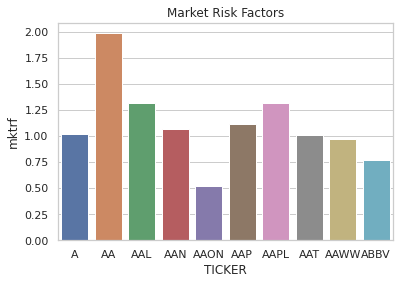

In [ ]:
# df_ff.mktrf
ff_graph = df_ff.head(10)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="TICKER", y="mktrf", data=ff_graph).set(title='Market Risk Factors')

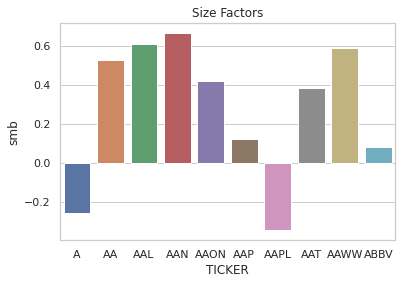

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="TICKER", y="smb", data=ff_graph).set(title='Size Factors')

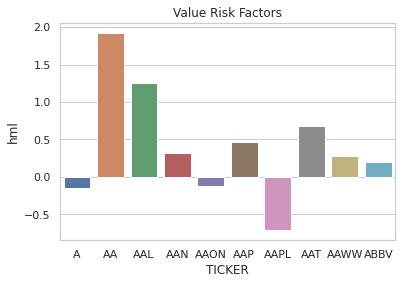

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="TICKER", y="hml", data=ff_graph).set(title='Value Risk Factors')

## Step 3: Calculate Financial Ratios

### Examine dataframe

In [ ]:
data_a4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   at        1886 non-null   float64
 10  ceq       1886 non-null   float64
 11  csho      1886 non-null   float64
 12  ebit      1886 non-null   float64
 13  lt        1886 non-null   float64
 14  ni        1886 non-null   float64
 15  sale      1886 non-null   float64
 16  costat    1886 non-null   object 
 17  prcc_c    1886 non-null   float64
dtypes: float64(8), int64(3), object(7)
memory usage: 265.3+ KB


###Print out header of dataframe

In [ ]:
data_a4.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,at,ceq,csho,ebit,lt,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,1539.700,974.4,35.375,65.50,565.300,35.80,1651.400,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,66467.000,-7340.0,647.728,-5514.00,73807.000,-1993.00,29882.000,A,17.96
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,22003.222,5906.2,112.927,805.31,15981.762,618.72,3803.835,A,70.59
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,75196.000,35802.0,1764.082,8966.00,39172.000,7071.00,43075.000,A,140.74
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,12419.000,7497.0,1207.000,3678.00,4922.000,3162.00,16434.000,A,143.90


###Rename tic column to "Ticker" to match WRDS data "Ticker" column for stock data


In [ ]:
data_a4.rename(columns={'tic':'Ticker'}, inplace=True)
data_a4.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,at,ceq,csho,ebit,lt,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,1539.700,974.4,35.375,65.50,565.300,35.80,1651.400,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,66467.000,-7340.0,647.728,-5514.00,73807.000,-1993.00,29882.000,A,17.96
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,22003.222,5906.2,112.927,805.31,15981.762,618.72,3803.835,A,70.59
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,75196.000,35802.0,1764.082,8966.00,39172.000,7071.00,43075.000,A,140.74
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,12419.000,7497.0,1207.000,3678.00,4922.000,3162.00,16434.000,A,143.90


### Merge datasets

In [ ]:
merged_df = pd.merge(data_pt, data_a4, on='Ticker', how='inner')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   gvkey     1886 non-null   int64  
 4   datadate  1886 non-null   int64  
 5   fyear     1886 non-null   int64  
 6   indfmt    1886 non-null   object 
 7   consol    1886 non-null   object 
 8   popsrc    1886 non-null   object 
 9   datafmt   1886 non-null   object 
 10  curcd     1886 non-null   object 
 11  at        1886 non-null   float64
 12  ceq       1886 non-null   float64
 13  csho      1886 non-null   float64
 14  ebit      1886 non-null   float64
 15  lt        1886 non-null   float64
 16  ni        1886 non-null   float64
 17  sale      1886 non-null   float64
 18  costat    1886 non-null   object 
 19  prcc_c    1886 non-null   float64
dtypes: float64(9), int64(3), objec

In [ ]:
# examine merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   gvkey     1886 non-null   int64  
 4   datadate  1886 non-null   int64  
 5   fyear     1886 non-null   int64  
 6   indfmt    1886 non-null   object 
 7   consol    1886 non-null   object 
 8   popsrc    1886 non-null   object 
 9   datafmt   1886 non-null   object 
 10  curcd     1886 non-null   object 
 11  at        1886 non-null   float64
 12  ceq       1886 non-null   float64
 13  csho      1886 non-null   float64
 14  ebit      1886 non-null   float64
 15  lt        1886 non-null   float64
 16  ni        1886 non-null   float64
 17  sale      1886 non-null   float64
 18  costat    1886 non-null   object 
 19  prcc_c    1886 non-null   float64
dtypes: float64(9), int64(3), objec

In [ ]:
 merged_df.head()

,Ticker,Name,RetYTD,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,at,ceq,csho,ebit,lt,ni,sale,costat,prcc_c
0,A,Agilent Technologies,-0.2080,126554,20211031,2021,INDL,C,D,STD,USD,10705.000,5389.000,302.208,1409.000,5316.000,1210.000,6319.000,A,159.65
1,AA,Alcoa Corp,0.4731,27638,20211231,2021,INDL,C,D,STD,USD,15025.000,4672.000,184.100,2077.000,8741.000,429.000,12152.000,A,59.58
2,AAL,American Airlines Gp,0.0579,1045,20211231,2021,INDL,C,D,STD,USD,66467.000,-7340.000,647.728,-5514.000,73807.000,-1993.000,29882.000,A,17.96
3,AAN,Aarons Holdings Company,-0.1327,37445,20211231,2021,INDL,C,D,STD,USD,1441.265,718.166,30.978,157.837,723.099,109.934,1845.504,A,24.65
4,AAON,Aaon Inc,-0.3456,21542,20211231,2021,INDL,C,D,STD,USD,650.180,466.170,52.528,73.632,184.010,58.758,534.517,A,79.43


In [ ]:
# check dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   gvkey     1886 non-null   int64  
 4   datadate  1886 non-null   int64  
 5   fyear     1886 non-null   int64  
 6   indfmt    1886 non-null   object 
 7   consol    1886 non-null   object 
 8   popsrc    1886 non-null   object 
 9   datafmt   1886 non-null   object 
 10  curcd     1886 non-null   object 
 11  at        1886 non-null   float64
 12  ceq       1886 non-null   float64
 13  csho      1886 non-null   float64
 14  ebit      1886 non-null   float64
 15  lt        1886 non-null   float64
 16  ni        1886 non-null   float64
 17  sale      1886 non-null   float64
 18  costat    1886 non-null   object 
 19  prcc_c    1886 non-null   float64
dtypes: float64(9), int64(3), objec

In [ ]:
# check for duplicates
merged_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1881    False
1882    False
1883    False
1884    False
1885    False
Length: 1886, dtype: bool

### Create Ratios for each stock



In [ ]:
# first let's create the market value column
merged_df['market_value'] = merged_df.prcc_c * merged_df.csho

In [ ]:
# let's also create other columns that will come in handy
merged_df.rename(columns={"at": "assets"}, inplace=True)

In [ ]:
# check dataframe once more
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        1886 non-null   object 
 1   Name          1886 non-null   object 
 2   RetYTD        1886 non-null   float64
 3   gvkey         1886 non-null   int64  
 4   datadate      1886 non-null   int64  
 5   fyear         1886 non-null   int64  
 6   indfmt        1886 non-null   object 
 7   consol        1886 non-null   object 
 8   popsrc        1886 non-null   object 
 9   datafmt       1886 non-null   object 
 10  curcd         1886 non-null   object 
 11  assets        1886 non-null   float64
 12  ceq           1886 non-null   float64
 13  csho          1886 non-null   float64
 14  ebit          1886 non-null   float64
 15  lt            1886 non-null   float64
 16  ni            1886 non-null   float64
 17  sale          1886 non-null   float64
 18  costat        1886 non-null 

In [ ]:
# let's create all the ratios

# market ratios
merged_df['P/E_ratio'] = merged_df['market_value'] / merged_df['ni'] #price to equity ratio
merged_df['P/S_ratio'] = merged_df['market_value'] / merged_df['sale'] #price to sales ratio
merged_df['P/B_ratio'] = merged_df['market_value'] / merged_df['ceq'] #price to book ratio
merged_df['P/EBIT_ratio'] = merged_df['market_value'] / merged_df['ebit'] #price to ebit ratio

# invert the market ratios
merged_df['E/P_ratio'] = 1 / merged_df['P/E_ratio']
merged_df['S/P_ratio'] = 1 / merged_df['P/S_ratio']
merged_df['B/P_ratio'] = 1 / merged_df['P/B_ratio']
merged_df['EBIT/P_ratio'] = 1 / merged_df['P/EBIT_ratio']

# other ratios
merged_df['net_profit_margin'] = merged_df['ni'] / merged_df['sale']
merged_df['debt_ratio'] = merged_df['lt'] / merged_df['assets']
merged_df['roa'] = merged_df['ni'] / merged_df['assets'] #return on assets
merged_df['roe'] = merged_df['ni'] / merged_df['market_value'] #return on equity
merged_df['D/E_ratio'] = merged_df['lt'] / merged_df['market_value'] #debt to equity ratio
merged_df['EPS'] = merged_df['ni']/merged_df['csho'] #earnings per share


###For the ratios check for missing values, outliers and data errors. We should also consider winsorizing or log transforming where applicable



In [ ]:
# check missing values
merged_df.isna().sum()

Ticker               0
Name                 0
RetYTD               0
gvkey                0
datadate             0
fyear                0
indfmt               0
consol               0
popsrc               0
datafmt              0
curcd                0
assets               0
ceq                  0
csho                 0
ebit                 0
lt                   0
ni                   0
sale                 0
costat               0
prcc_c               0
market_value         0
P/E_ratio            0
P/S_ratio            0
P/B_ratio            0
P/EBIT_ratio         0
E/P_ratio            0
S/P_ratio            0
B/P_ratio            0
EBIT/P_ratio         0
net_profit_margin    0
debt_ratio           0
roa                  0
roe                  0
D/E_ratio            0
EPS                  0
dtype: int64

In [ ]:
# check outliers and distribution of columns
merged_df.describe()

,RetYTD,gvkey,datadate,fyear,assets,ceq,csho,ebit,lt,ni,...,E/P_ratio,S/P_ratio,B/P_ratio,EBIT/P_ratio,net_profit_margin,debt_ratio,roa,roe,D/E_ratio,EPS
count,1886.000000,1886.000000,1.886000e+03,1886.000000,1.886000e+03,1886.000000,1886.000000,1886.000000,1.886000e+03,1886.000000,...,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,-0.063484,62189.838282,2.021110e+07,2020.911983,2.622079e+04,5024.835206,216.216609,1309.807222,2.095505e+04,942.737848,...,0.027009,0.765997,0.422120,0.060538,NaN,0.760677,0.023572,0.027009,1.561028,4.408250
std,0.243801,67853.146760,2.954896e+02,0.283395,1.493189e+05,16277.563302,617.870176,5154.949448,1.355288e+05,4208.808452,...,0.136353,1.439881,0.424100,0.130324,NaN,2.864605,0.171422,0.136353,2.764246,16.994272
min,-0.787400,1004.000000,2.021013e+07,2020.000000,2.689900e+01,-14999.000000,1.161000,-6273.000000,1.609000e+00,-9501.000000,...,-1.891725,-0.087004,-2.056645,-1.334204,-inf,0.008474,-1.759213,-1.891725,0.005926,-91.318754
25%,-0.199450,11641.250000,2.021123e+07,2021.000000,1.291068e+03,416.276000,37.220250,48.110500,6.544948e+02,16.138750,...,0.008113,0.176223,0.161112,0.019641,0.015657,0.460233,0.007584,0.008113,0.217034,0.287445
50%,-0.086750,25281.000000,2.021123e+07,2021.000000,4.124783e+03,1109.486000,73.807500,211.177000,2.580137e+03,135.238000,...,0.036704,0.350729,0.337004,0.056821,0.090344,0.633081,0.034187,0.036704,0.534134,2.407403
75%,0.038750,125591.250000,2.021123e+07,2021.000000,1.307137e+04,3316.116500,176.940000,807.034250,8.953416e+03,554.200000,...,0.076322,0.814565,0.613868,0.113822,0.199075,0.802777,0.079409,0.076322,1.427702,5.229402
max,1.735700,317264.000000,2.021123e+07,2021.000000,3.743567e+06,259289.000000,16426.786000,108949.000000,3.449440e+06,94680.000000,...,0.898517,27.543662,7.547555,0.974888,inf,80.482129,1.484070,0.898517,40.343655,490.956072


count    1886.000000
mean        0.027009
std         0.136353
min        -1.891725
25%         0.008113
50%         0.036704
75%         0.076322
max         0.898517
Name: E/P_ratio, dtype: float64


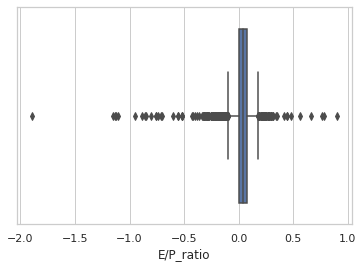

count    1886.000000
mean        0.765997
std         1.439881
min        -0.087004
25%         0.176223
50%         0.350729
75%         0.814565
max        27.543662
Name: S/P_ratio, dtype: float64


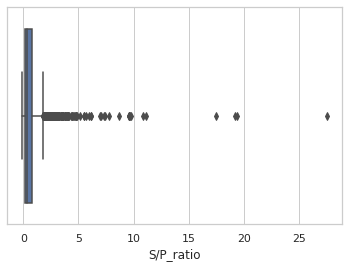

count    1886.000000
mean        0.422120
std         0.424100
min        -2.056645
25%         0.161112
50%         0.337004
75%         0.613868
max         7.547555
Name: B/P_ratio, dtype: float64


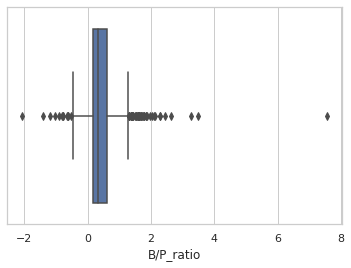

count    1886.000000
mean        0.060538
std         0.130324
min        -1.334204
25%         0.019641
50%         0.056821
75%         0.113822
max         0.974888
Name: EBIT/P_ratio, dtype: float64


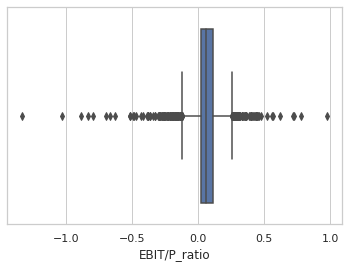

count    1886.000000
mean             NaN
std              NaN
min             -inf
25%         0.015657
50%         0.090344
75%         0.199075
max              inf
Name: net_profit_margin, dtype: float64


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


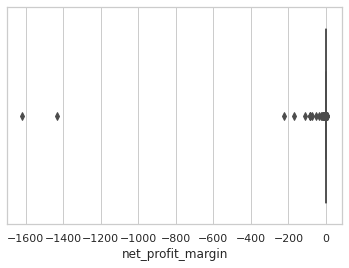

count    1886.000000
mean        0.760677
std         2.864605
min         0.008474
25%         0.460233
50%         0.633081
75%         0.802777
max        80.482129
Name: debt_ratio, dtype: float64


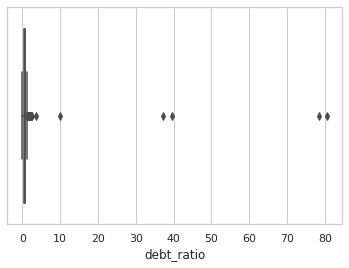

count    1886.000000
mean        0.023572
std         0.171422
min        -1.759213
25%         0.007584
50%         0.034187
75%         0.079409
max         1.484070
Name: roa, dtype: float64


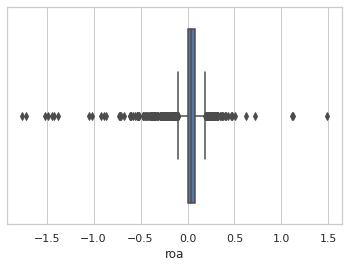

count    1886.000000
mean        0.027009
std         0.136353
min        -1.891725
25%         0.008113
50%         0.036704
75%         0.076322
max         0.898517
Name: roe, dtype: float64


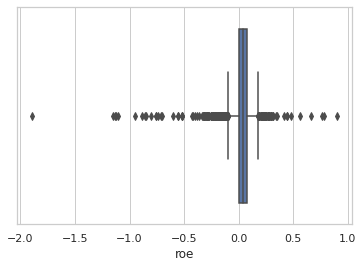

count    1886.000000
mean        1.561028
std         2.764246
min         0.005926
25%         0.217034
50%         0.534134
75%         1.427702
max        40.343655
Name: D/E_ratio, dtype: float64


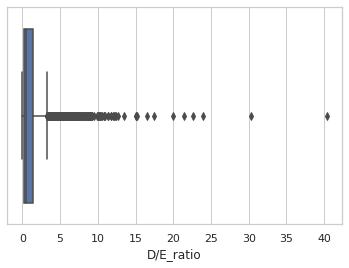

count    1886.000000
mean        4.408250
std        16.994272
min       -91.318754
25%         0.287445
50%         2.407403
75%         5.229402
max       490.956072
Name: EPS, dtype: float64


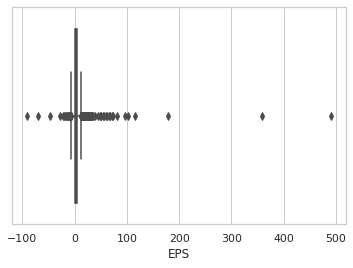

In [ ]:
# let's loop over to check outliers and skewness of ratio columns
cols = ['E/P_ratio', 'S/P_ratio','B/P_ratio', 'EBIT/P_ratio', 'net_profit_margin'
        , 'debt_ratio','roa', 'roe', 'D/E_ratio', 'EPS']



for col in cols:
    print(merged_df[col].describe())
    sns.boxplot(x=merged_df[col])
    plt.show();

Let's winsorize the data as there are several outliers

In [ ]:
# winsorize outliers based on boxplot distributions

for col in cols:
  merged_df[col] = winsorize(merged_df[col], (0.01,0.01))

count    1886.000000
mean        0.028873
std         0.104512
min        -0.521213
25%         0.008113
50%         0.036704
75%         0.076322
max         0.279700
Name: E/P_ratio, dtype: float64


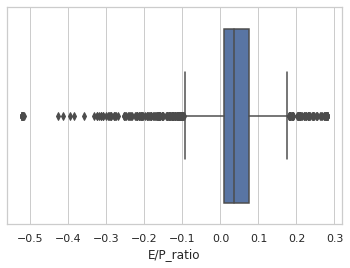

count    1886.000000
mean        0.715725
std         0.984952
min         0.000060
25%         0.176223
50%         0.350729
75%         0.814565
max         6.119348
Name: S/P_ratio, dtype: float64


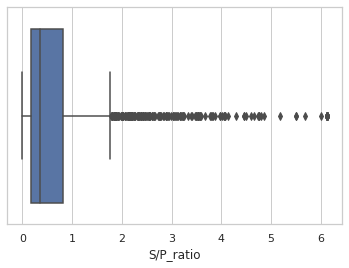

count    1886.000000
mean        0.418517
std         0.357616
min        -0.337273
25%         0.161112
50%         0.337004
75%         0.613868
max         1.677414
Name: B/P_ratio, dtype: float64


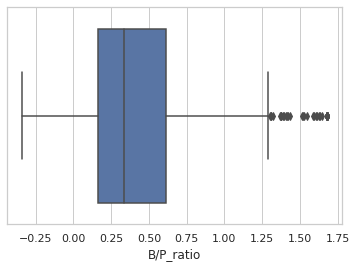

count    1886.000000
mean        0.061672
std         0.110981
min        -0.378436
25%         0.019641
50%         0.056821
75%         0.113822
max         0.415467
Name: EBIT/P_ratio, dtype: float64


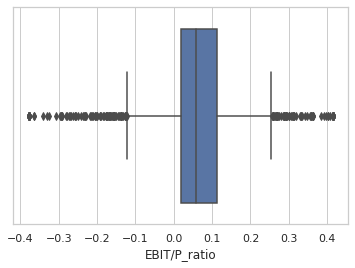

count    1886.000000
mean       -2.083802
std        17.769465
min      -171.075493
25%         0.015657
50%         0.090344
75%         0.199075
max         0.908416
Name: net_profit_margin, dtype: float64


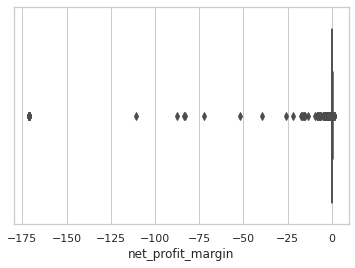

count    1886.000000
mean        0.631315
std         0.256761
min         0.086737
25%         0.460233
50%         0.633081
75%         0.802777
max         1.552428
Name: debt_ratio, dtype: float64


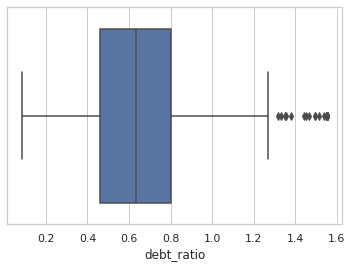

count    1886.000000
mean        0.025727
std         0.130224
min        -0.612289
25%         0.007584
50%         0.034187
75%         0.079409
max         0.325773
Name: roa, dtype: float64


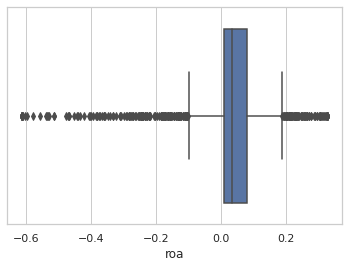

count    1886.000000
mean        0.028873
std         0.104512
min        -0.521213
25%         0.008113
50%         0.036704
75%         0.076322
max         0.279700
Name: roe, dtype: float64


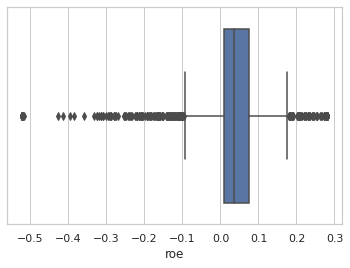

count    1886.000000
mean        1.500729
std         2.347901
min         0.018731
25%         0.217034
50%         0.534134
75%         1.427702
max        11.715856
Name: D/E_ratio, dtype: float64


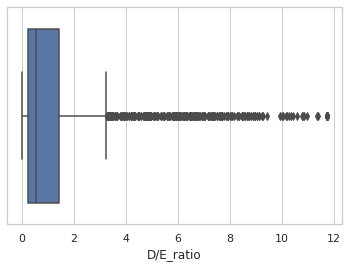

count    1886.000000
mean        3.823805
std         6.585012
min        -8.363556
25%         0.287445
50%         2.407403
75%         5.229402
max        38.903246
Name: EPS, dtype: float64


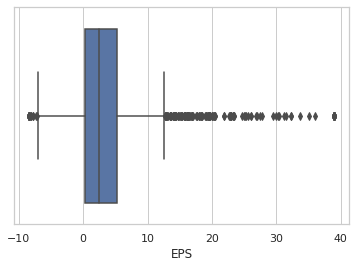

In [ ]:
# let's loop over to check outliers and skewness of ratio columns
cols = ['E/P_ratio', 'S/P_ratio','B/P_ratio', 'EBIT/P_ratio', 'net_profit_margin', 
        'debt_ratio','roa', 'roe', 'D/E_ratio', 'EPS']



for col in cols:
    print(merged_df[col].describe())
    sns.boxplot(x=merged_df[col])
    plt.show();

### Save the final data for the ratios variables



In [ ]:
final_df = merged_df[['Ticker', 'E/P_ratio', 'S/P_ratio','B/P_ratio', 'EBIT/P_ratio', 'net_profit_margin',
                      'debt_ratio','roa', 'roe', 'D/E_ratio', 'EPS','RetYTD']]

In [ ]:
final_df.head()

,Ticker,E/P_ratio,S/P_ratio,B/P_ratio,EBIT/P_ratio,net_profit_margin,debt_ratio,roa,roe,D/E_ratio,EPS,RetYTD
0,A,0.025079,0.130970,0.111695,0.029204,0.191486,0.496590,0.113031,0.025079,0.110182,4.003865,-0.2080
1,AA,0.039111,1.107882,0.425940,0.189357,0.035303,0.581764,0.028552,0.039111,0.796906,2.330255,0.4731
2,AAL,-0.171320,2.568684,-0.337273,-0.378436,-0.066696,1.110431,-0.029985,-0.171320,6.344517,-3.076909,0.0579
3,AAN,0.143967,2.416822,0.940491,0.206699,0.059569,0.501711,0.076276,0.143967,0.946951,3.548777,-0.1327
4,AAON,0.014083,0.128111,0.111730,0.017648,0.109927,0.283014,0.090372,0.014083,0.044103,1.118603,-0.3456


In [ ]:
ratios_df = final_df.drop('RetYTD', axis = 1)
ratios_df.to_csv("Fin-Ratios.csv")

### Graphs

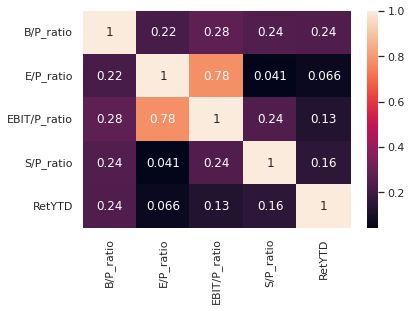

In [ ]:
corr_features=list(['B/P_ratio', 'E/P_ratio', 'EBIT/P_ratio', 'S/P_ratio', 'RetYTD'])

sns.heatmap(final_df[corr_features].corr(), annot=True);

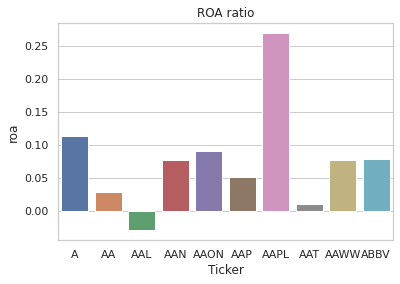

In [ ]:
# final_df

fr_graph = final_df.head(10)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Ticker", y="roa", data=fr_graph).set(title='ROA ratio')

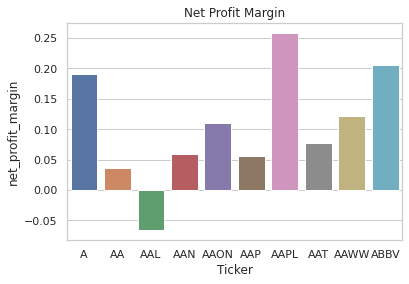

In [ ]:
# fr_graph = final_df.head(10)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Ticker", y="net_profit_margin", data=fr_graph).set(title='Net Profit Margin')

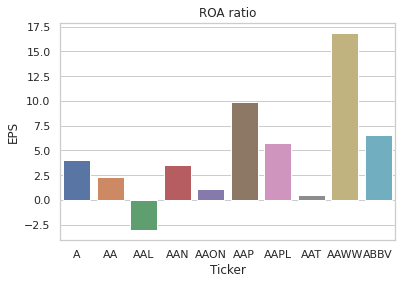

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Ticker", y="EPS", data=fr_graph).set(title='ROA ratio')

## Step 4: Industry Indicators

### Merge datasets

In [ ]:
df_ii = pd.merge(data_pt, data_a5, on='Ticker', how='left')

In [ ]:
# examine merged dataset
df_ii.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   gvkey     1886 non-null   int64  
 4   datadate  1886 non-null   int64  
 5   fyear     1886 non-null   int64  
 6   indfmt    1886 non-null   object 
 7   consol    1886 non-null   object 
 8   popsrc    1886 non-null   object 
 9   datafmt   1886 non-null   object 
 10  curcd     1886 non-null   object 
 11  costat    1886 non-null   object 
 12  ggroup    1886 non-null   int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 206.3+ KB


In [ ]:
# check for duplicates
df_ii.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1881    False
1882    False
1883    False
1884    False
1885    False
Length: 1886, dtype: bool

In [ ]:
df_ii.drop(["Name ","gvkey", "datadate", "fyear", "indfmt", "consol", "popsrc", "datafmt",	"curcd", "costat"], axis=1, inplace=True)


In [ ]:
df_ii.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   RetYTD  1886 non-null   float64
 2   ggroup  1886 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 58.9+ KB


In [ ]:
df_ii.isna().sum()

Ticker    0
RetYTD    0
ggroup    0
dtype: int64

In [ ]:
df_ii['ggroup'].nunique()

24

In [ ]:
df_ii['ggroup'].value_counts()

2010    183
4010    179
3520    163
6010    131
3510    121
4510    118
1510     95
4020     92
2550     86
4520     82
1010     75
2530     64
2020     63
2520     63
4030     61
5510     58
4530     55
3020     44
5020     42
2030     39
2510     25
3010     17
3030     17
5010     13
Name: ggroup, dtype: int64

In [ ]:
df_ii.head()

,Ticker,RetYTD,ggroup
0,A,-0.2080,3520
1,AA,0.4731,1510
2,AAL,0.0579,2030
3,AAN,-0.1327,2550
4,AAON,-0.3456,2010


In [ ]:
df_ii.sort_values(by='ggroup')

,Ticker,RetYTD,ggroup
830,HP,1.0620,1010
907,INT,0.0023,1010
906,INSW,0.4080,1010
1553,SLB,0.4441,1010
1142,MPC,0.3627,1010
...,...,...,...
1278,OFC,0.0072,6010
500,DEI,-0.0743,6010
1462,RHP,0.0332,6010
700,FR,-0.0698,6010


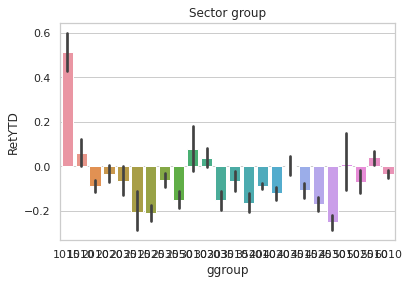

In [ ]:
fr_graph = final_df.head(10)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="ggroup", y="RetYTD", data=df_ii).set(title='Sector group')

In [ ]:
df_ii.groupby(['ggroup']).RetYTD.mean().sort_values(ascending=False)

ggroup
1010    0.515035
3010    0.078312
1510    0.057846
5510    0.040759
3020    0.038780
5010    0.011838
4030    0.003779
2020   -0.035157
6010   -0.035826
2530   -0.062583
3510   -0.066432
2030   -0.067454
5020   -0.070871
4010   -0.087832
2010   -0.090548
4510   -0.108644
4020   -0.122515
2550   -0.151223
3030   -0.153771
3520   -0.163937
4520   -0.172065
2510   -0.207992
2520   -0.208598
4530   -0.252813
Name: RetYTD, dtype: float64

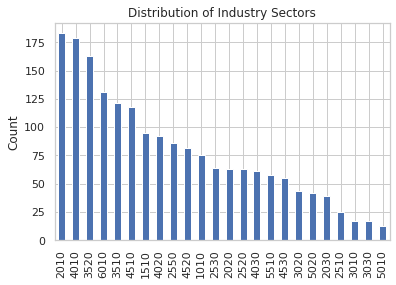

In [ ]:
# looking at the distribution of the sectors
# create the bar plot
ax = df_ii['ggroup'].value_counts().plot(kind='bar')
# rotate xtick labels
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# set the y-axis label
ax.set_ylabel("Count")
# set the title
ax.set_title("Distribution of Industry Sectors");

###Create Industry Indicators

In [ ]:
df_ind = pd.get_dummies(df_ii, columns=['ggroup'])
df_ind

,Ticker,RetYTD,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,-0.2080,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AA,0.4731,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAL,0.0579,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAN,-0.1327,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAON,-0.3456,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,0.2002,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1882,ZION,-0.0038,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1883,ZNGA,0.3969,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1884,ZTS,-0.2325,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_ind.to_csv("Industry.csv", index=False)

## Step 5: Run OLS explanatory for 4 categories:



### a. Risk Regressions:

- i. Ret(i) = a + b1*MktExposure(i) + b2*SizeExposure(i) +
b3*ValueExposure(i) + e


In [ ]:
# merge datasets df_ff & data_pt on Ticker

df_ff.rename(columns={'TICKER':'Ticker'}, inplace=True)

risk_reg = pd.merge(data_pt, df_ff, on='Ticker', how='left')
risk_reg.head(10)

,Ticker,Name,RetYTD,mktrf,smb,hml
0,A,Agilent Technologies,-0.2080,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,1.984149,0.527862,1.924844
2,AAL,American Airlines Gp,0.0579,1.315550,0.612825,1.248123
3,AAN,Aarons Holdings Company,-0.1327,1.063239,0.668200,0.315612
4,AAON,Aaon Inc,-0.3456,0.516779,0.422130,-0.117068
5,AAP,Advance Auto Parts Inc,-0.0884,1.112646,0.123161,0.469651
6,AAPL,Apple Inc,-0.0692,1.314647,-0.344850,-0.714986
7,AAT,American Assets Trust,-0.0384,1.007945,0.384752,0.685424
8,AAWW,Atlas Air Ww,-0.2727,0.971779,0.591275,0.283819
9,ABBV,Abbvie Inc,0.1987,0.774071,0.083434,0.204134


In [ ]:
# only keep columns we need for regression
risk_reg = risk_reg.drop(columns=['Ticker', 'Name '])
#let's look at the updated data
risk_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RetYTD  1886 non-null   float64
 1   mktrf   1886 non-null   float64
 2   smb     1886 non-null   float64
 3   hml     1886 non-null   float64
dtypes: float64(4)
memory usage: 73.7 KB


In [ ]:
# select the independent variables for mkt, size and value
X1 = risk_reg[['mktrf', 'smb', 'hml']]
y1 = risk_reg['RetYTD']

# add constant column
X1 = sm.add_constant(X1) 
model = sm.OLS(y1, X1).fit()

model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     65.99
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.43e-40
Time:                        01:50:26   Log-Likelihood:                 80.608
No. Observations:                1886   AIC:                            -153.2
Df Residuals:                    1882   BIC:                            -131.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0982      0.011     -8.778      0.000      -0.120      -0.076
mktrf          0.0084      0.009      0.976      0.329      -0.009       0.025
smb           -0.0121      0.004     -2.770      0.006      -0.021      -0.004
hml            0.1073      0.008     13.866      0.000       0.092       0.122
==============================================================================
Omnibus:                      641.661   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3596.936
Skew:                           1.491   Prob(JB):                         0.00
Kurtosis:                       9.073   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ii. Interpret and explain your findings (focus on R2, Adj R2 and
coefficients)

- As we see from the regression above, R2 is 0.095. More specifically, R-squared gives you the percentage variation in y explained by x-variables. Given R-squared and Adjusted R-squared from this regression, 9.5% of the stocks' return explained by market, size and value risk factors 

- Constant
    - The constant has a value of -0.0982. The constant is alpha in this case P-value is less than 0.05 and t-stat is more than 1.95 meaning that it is statistically significant and we are confident that the value is not 0. Over the early months of 2022, beyond what happened with the stock market(mktrf), and the other two risk factors, the stock portfolio went down by 9.8% on average.
- mkrtf
    - The mktrf has a value of 0.0084. This is the coefficient of the market risk. P-value is more than 0.05 and t-stat's absolute value is less than 1.95 so it is not statistically significant. The value of the coefficient tells us that the average value of the stock portfolio is less volatile than the market since it is less than 1. Since the 95% confidence interval does not include 1, we can reject the assertion that the value includes 1.
- smb
    - The smb has a value of -0.0121. This is the coefficient of the size risk. P-value is less than 0.05 and t-stat is more than 1.95 meaning that it is statistically significant and we are confident that the value is not 0. The sign of the coefficient tells us that the portfolio of stocks looks more like large stocks. This finding makes sense since the Russell 3000 Index is a market-capitalization-weighted equity index that seeks to track 3000 of the largest U.S.-traded stocks. Since the 95% confidence interval does not include 1, we can reject the assertion that the value includes 0.
- hml
    - The hml has a value of 0.1073. This is the coefficient of the value risk. P-value is less than 0.05 and t-stat is more than 1.95 meaning that it is statistically significant and we are confident that the value is not 0. The sign of the coefficient tells us that the portfolio of stocks looks more like value stocks. Since the 95% confidence interval does not include 1, we can reject the assertion that the value includes 0.

### b. Financial Characteristics:

i. Ret(i) = a + c1*Ratio1(i) + c2*Ratio2(i) + … + c10*Ratio10 (i) + e


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             1886 non-null   object 
 1   E/P_ratio          1886 non-null   float64
 2   S/P_ratio          1886 non-null   float64
 3   B/P_ratio          1886 non-null   float64
 4   EBIT/P_ratio       1886 non-null   float64
 5   net_profit_margin  1886 non-null   float64
 6   debt_ratio         1886 non-null   float64
 7   roa                1886 non-null   float64
 8   roe                1886 non-null   float64
 9   D/E_ratio          1886 non-null   float64
 10  EPS                1886 non-null   float64
 11  RetYTD             1886 non-null   float64
dtypes: float64(11), object(1)
memory usage: 191.5+ KB


In [ ]:
# select the independent variables for ratios

X2 = final_df.drop(columns=['RetYTD', 'Ticker'])
y2 = final_df['RetYTD']

# add constant column
X2 = sm.add_constant(X2) 
model = sm.OLS(y2, X2).fit()

model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     26.14
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           7.90e-43
Time:                        01:50:26   Log-Likelihood:                 97.678
No. Observations:                1886   AIC:                            -175.4
Df Residuals:                    1876   BIC:                            -119.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2596      0.020    -12.907      0.000      -0.299      -0.220
E/P_ratio            -0.2016      0.052     -3.871      0.000      -0.304      -0.099
S/P_ratio             0.0103      0.006      1.726      0.085      -0.001       0.022
B/P_ratio             0.2477      0.021     11.953      0.000       0.207       0.288
EBIT/P_ratio          0.3173      0.087      3.643      0.000       0.146       0.488
net_profit_margin    -0.0007      0.000     -1.975      0.048      -0.001   -4.63e-06
debt_ratio            0.1767      0.028      6.321      0.000       0.122       0.231
roa                   0.3422      0.064      5.349      0.000       0.217       0.468
roe                  -0.2016      0.052     -3.871      0.000      -0.304      -0.099
D/E_ratio            -0.0231      0.004     -6.514      0.000      -0.030      -0.016
EPS                  -0.0026      0.001     -2.706      0.007      -0.004      -0.001
==============================================================================
Omnibus:                      648.100   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4020.436
Skew:                           1.473   Prob(JB):                         0.00
Kurtosis:                       9.518   Cond. No.                     4.33e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

ii. Interpret and explain your findings (focus on R2, Adj R2 and
coefficients)

R-squared and Adjusted R-squared tells us that around 10% of the variance in the stocks' return is explained by the financial ratios used as independent variables. The ratios are better at explaining the variance in stock returns (Adj R2~10%) compared to the fama french variables.

- All of the ratios, except for S/P ratio, have p-values less than 0.05 and t-stat absolute values of more than 1.95, meaning that they are statistically significant.

- Notable coefficients
    - ROA (Return on Assets) has the highest positive coefficient value at 0.3422. This means that when ROA increases by 1, the return on the stock portfolio is expected to increase by 0.3422.
    - EBIT/P_ratio (EBIT to Price ratio) has the second highest positive coefficient value at 0.3173. This means that when EBIT-to-Price ratio increases by 1, the return on the stock portfolio is expected to increase by 0.3173.
    - B/P_ratio (Book to Price ratio) has the third highest positive coefficient value at 0.2477. This means that when Book to Price ratio increases by 1, the return on the stock portfolio is expected to increase by 0.2477.



### c. Industry Dummies:

i. Ret(i) = a + coefficients*IndustryDummies + e


In [ ]:
# only keep independent variables for industry indicators
X3 = df_ind.drop(columns=['RetYTD', 'Ticker'])

y3 = df_ind['RetYTD']

# add constant
# X3 = sm.add_constant(X3) 
model = sm.OLS(y3, X3).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        01:50:26   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1010     0.5150      0.023     22.140      0.000       0.469       0.561
ggroup_1510     0.0578      0.021      2.799      0.005       0.017       0.098
ggroup_2010    -0.0905      0.015     -6.080      0.000      -0.120      -0.061
ggroup_2020    -0.0352      0.025     -1.385      0.166      -0.085       0.015
ggroup_2030    -0.0675      0.032     -2.091      0.037      -0.131      -0.004
ggroup_2510    -0.2080      0.040     -5.162      0.000      -0.287      -0.129
ggroup_2520    -0.2086      0.025     -8.218      0.000      -0.258      -0.159
ggroup_2530    -0.0626      0.025     -2.485      0.013      -0.112      -0.013
ggroup_2550    -0.1512      0.022     -6.961      0.000      -0.194      -0.109
ggroup_3010     0.0783      0.049      1.603      0.109      -0.018       0.174
ggroup_3020     0.0388      0.030      1.277      0.202      -0.021       0.098
ggroup_3030    -0.1538      0.049     -3.147      0.002      -0.250      -0.058
ggroup_3510    -0.0664      0.018     -3.627      0.000      -0.102      -0.031
ggroup_3520    -0.1639      0.016    -10.389      0.000      -0.195      -0.133
ggroup_4010    -0.0878      0.015     -5.833      0.000      -0.117      -0.058
ggroup_4020    -0.1225      0.021     -5.833      0.000      -0.164      -0.081
ggroup_4030     0.0038      0.026      0.146      0.884      -0.047       0.054
ggroup_4510    -0.1086      0.019     -5.858      0.000      -0.145      -0.072
ggroup_4520    -0.1721      0.022     -7.734      0.000      -0.216      -0.128
ggroup_4530    -0.2528      0.027     -9.307      0.000      -0.306      -0.200
ggroup_5010     0.0118      0.056      0.212      0.832      -0.098       0.121
ggroup_5020    -0.0709      0.031     -2.280      0.023      -0.132      -0.010
ggroup_5510     0.0408      0.026      1.541      0.124      -0.011       0.093
ggroup_6010    -0.0358      0.018     -2.035      0.042      -0.070      -0.001
==============================================================================
Omnibus:                      403.265   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2314.656
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                       8.136   Cond. No.                         3.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ii. Interpret and explain your findings (focus on R2, Adj R2 and
coefficients)

R-squared and Adjusted R-squared tells us that around 31% of the variance in the stocks' return is explained by the industry indicators used as independent variables. The industry indicators are even better at explaining the variance in stock returns (Adj R2~31%) compared to the fama french variables and the ratios.

- All industry indicators (except for ggroup_2020, ggroup_3010, ggroup_3020, ggroup_4030, ggroup_5010, ggroup_5510) have p-values less than 0.05 and t-stat absolute values of more than 1.95, meaning that they are statistically significant.

- Notable coefficients
    - ggroup_1010 (Energy Sector) has the highest positive coefficient value at 0.5150. When ggroup_1010 increases by 1, the return on the stock portfolio is expected to increase by 0.5150.
    - ggroup_4530 (Semiconductors & Semiconductor Equipment Sector) has a negative coefficient value at -0.2528. When ggroup_4530 increases by 1, the return on the stock portfolio is expected to decrease by 0.2528.
    - ggroup_2520 (Consumer Durables & Apparel Sector) has a negative coefficient value at -0.2086. When ggroup_2520 increases by 1, the return on the stock portfolio is expected to decrease by 0.2086.
    - ggroup_2510 (Automobiles & Components Sector) has a negative coefficient value at -0.2080. When ggroup_2510 increases by 1, the return on the stock portfolio is expected to decrease by 0.2080.



### d. Combined Regressions:

i. Combine the various regressions in steps (a-c) above.


#### First let's look at the datasets we have to use: Risk, Financial ratios and Industry indicator

In [ ]:
df_ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   mktrf   1886 non-null   float64
 2   smb     1886 non-null   float64
 3   hml     1886 non-null   float64
dtypes: float64(3), object(1)
memory usage: 73.7+ KB


In [ ]:
ratios_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             1886 non-null   object 
 1   E/P_ratio          1886 non-null   float64
 2   S/P_ratio          1886 non-null   float64
 3   B/P_ratio          1886 non-null   float64
 4   EBIT/P_ratio       1886 non-null   float64
 5   net_profit_margin  1886 non-null   float64
 6   debt_ratio         1886 non-null   float64
 7   roa                1886 non-null   float64
 8   roe                1886 non-null   float64
 9   D/E_ratio          1886 non-null   float64
 10  EPS                1886 non-null   float64
dtypes: float64(10), object(1)
memory usage: 176.8+ KB


In [ ]:
df_ind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ticker       1886 non-null   object 
 1   RetYTD       1886 non-null   float64
 2   ggroup_1010  1886 non-null   uint8  
 3   ggroup_1510  1886 non-null   uint8  
 4   ggroup_2010  1886 non-null   uint8  
 5   ggroup_2020  1886 non-null   uint8  
 6   ggroup_2030  1886 non-null   uint8  
 7   ggroup_2510  1886 non-null   uint8  
 8   ggroup_2520  1886 non-null   uint8  
 9   ggroup_2530  1886 non-null   uint8  
 10  ggroup_2550  1886 non-null   uint8  
 11  ggroup_3010  1886 non-null   uint8  
 12  ggroup_3020  1886 non-null   uint8  
 13  ggroup_3030  1886 non-null   uint8  
 14  ggroup_3510  1886 non-null   uint8  
 15  ggroup_3520  1886 non-null   uint8  
 16  ggroup_4010  1886 non-null   uint8  
 17  ggroup_4020  1886 non-null   uint8  
 18  ggroup_4030  1886 non-null   uint8  
 19  ggroup

Let's combine the datasets into one

In [ ]:
final_merged_df = pd.merge(df_ff, ratios_df, on = 'Ticker', how = 'left')
final_merged_df = pd.merge(final_merged_df, df_ind, on = 'Ticker', how = 'left')

In [ ]:
final_merged_df.head()

,Ticker,mktrf,smb,hml,E/P_ratio,S/P_ratio,B/P_ratio,EBIT/P_ratio,net_profit_margin,debt_ratio,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,1.014152,-0.253674,-0.143608,0.025079,0.130970,0.111695,0.029204,0.191486,0.496590,...,0,0,0,0,0,0,0,0,0,0
1,AA,1.984149,0.527862,1.924844,0.039111,1.107882,0.425940,0.189357,0.035303,0.581764,...,0,0,0,0,0,0,0,0,0,0
2,AAL,1.315550,0.612825,1.248123,-0.171320,2.568684,-0.337273,-0.378436,-0.066696,1.110431,...,0,0,0,0,0,0,0,0,0,0
3,AAN,1.063239,0.668200,0.315612,0.143967,2.416822,0.940491,0.206699,0.059569,0.501711,...,0,0,0,0,0,0,0,0,0,0
4,AAON,0.516779,0.422130,-0.117068,0.014083,0.128111,0.111730,0.017648,0.109927,0.283014,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             1886 non-null   object 
 1   mktrf              1886 non-null   float64
 2   smb                1886 non-null   float64
 3   hml                1886 non-null   float64
 4   E/P_ratio          1886 non-null   float64
 5   S/P_ratio          1886 non-null   float64
 6   B/P_ratio          1886 non-null   float64
 7   EBIT/P_ratio       1886 non-null   float64
 8   net_profit_margin  1886 non-null   float64
 9   debt_ratio         1886 non-null   float64
 10  roa                1886 non-null   float64
 11  roe                1886 non-null   float64
 12  D/E_ratio          1886 non-null   float64
 13  EPS                1886 non-null   float64
 14  RetYTD             1886 non-null   float64
 15  ggroup_1010        1886 non-null   uint8  
 16  ggroup_1510        1886 

In [ ]:
# let's drop Ticker so we only keep the columns that are meaningful for the regression
final_merged_df.drop('Ticker', axis =1, inplace = True)

In [ ]:
# only keep independent variables for all 3 previous models
X4 = final_merged_df.drop(columns=['RetYTD'])

y4 = final_merged_df['RetYTD']

# add constant
# X3 = sm.add_constant(X3) 
model = sm.OLS(y4, X4).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     33.50
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.29e-169
Time:                        01:50:27   Log-Likelihood:                 449.17
No. Observations:                1886   AIC:                            -826.3
Df Residuals:                    1850   BIC:                            -626.8
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
mktrf                -0.0158      0.008     -1.935      0.053      -0.032       0.000
smb                  -0.0172      0.004     -4.039      0.000      -0.026      -0.009
hml                   0.0636      0.009      7.306      0.000       0.047       0.081
E/P_ratio            -0.0542      0.045     -1.210      0.226      -0.142       0.034
S/P_ratio             0.0051      0.006      0.807      0.420      -0.007       0.018
B/P_ratio             0.1153      0.020      5.903      0.000       0.077       0.154
EBIT/P_ratio          0.1165      0.076      1.533      0.125      -0.033       0.266
net_profit_margin    -0.0005      0.000     -1.711      0.087      -0.001    7.09e-05
debt_ratio            0.0932      0.026      3.643      0.000       0.043       0.143
roa                   0.2172      0.059      3.657      0.000       0.101       0.334
roe                  -0.0542      0.045     -1.210      0.226      -0.142       0.034
D/E_ratio            -0.0050      0.004     -1.322      0.186      -0.012       0.002
EPS                  -0.0017      0.001     -2.020      0.044      -0.003   -4.92e-05
ggroup_1010           0.3583      0.036      9.939      0.000       0.288       0.429
ggroup_1510          -0.0674      0.029     -2.309      0.021      -0.125      -0.010
ggroup_2010          -0.1918      0.025     -7.584      0.000      -0.241      -0.142
ggroup_2020          -0.1455      0.032     -4.553      0.000      -0.208      -0.083
ggroup_2030          -0.1981      0.038     -5.227      0.000      -0.272      -0.124
ggroup_2510          -0.3296      0.046     -7.211      0.000      -0.419      -0.240
ggroup_2520          -0.3200      0.033     -9.726      0.000      -0.385      -0.256
ggroup_2530          -0.1640      0.035     -4.682      0.000      -0.233      -0.095
ggroup_2550          -0.2589      0.033     -7.828      0.000      -0.324      -0.194
ggroup_3010          -0.0511      0.053     -0.963      0.336      -0.155       0.053
ggroup_3020          -0.0779      0.035     -2.217      0.027      -0.147      -0.009
ggroup_3030          -0.2554      0.051     -4.990      0.000      -0.356      -0.155
ggroup_3510          -0.1078      0.025     -4.276      0.000      -0.157      -0.058
ggroup_3520          -0.1409      0.025     -5.558      0.000      -0.191      -0.091
ggroup_4010          -0.2655      0.033     -8.031      0.000      -0.330      -0.201
ggroup_4020          -0.2577      0.032     -8.064      0.000      -0.320      -0.195
ggroup_4030          -0.1673      0.037     -4.578      0.000      -0.239      -0.096
ggroup_4510          -0.1449      0.027     -5.288      0.000      -0.199      -0.091
ggroup_4520          -0.2558      0.030     -8.606      0.000      -0.314      -0.197
ggroup_4530          -0.2984      0.032     -9.345      0.000      -0.361

ii. Interpret and explain your findings (focus on R2, Adj R2 and
coefficients)

R-squared and Adjusted R-squared tells us that around 37% of the stock returns variance is explained by the fama french metrics, financial ratios, and industry indicators, used as independent variables. This combined regression performs even better in explaining the variance in stock returns (Adj R2~37%) when adding more variables than the previous three standalone regressions. When analyzing the other three regressions, we can conclude that industry indicators explained most of the financial returns variance.

## Conclusion and recommendation

### Conclusion

This project covered a financial analysis of the Russell 3000 index stock returns. The Russell 3000 measures the performance of the largest 3,000 U.S. companies representing approximately 97% of the investable U.S. equity market. The data used was a sample of a large set of U.S. companies during the "Stock Market Shock" if early 2022.
First, we collected stock data from multiple datasets from the WRDS website. Then, we collected variables such as stock returns, financial ratios, Fama-French factor return data, and industry identifiers, amongst other variables.
We determined the risk exposures of the stocks by calculating the Fama-French exposures: market risk exposure, size risk exposure, and value/distress risk exposure. We also calculated financial ratios and industry indicators and handled missing values and outliers throughout the analysis. We used the average value for numeric columns wherever necessary to deal with missing values. For outliers, we winsorized the data.
Finally, we ran four regressions based on our previous categories: risk, financial characteristics, industry dummies, and a combined regression. The regressions showed that industry indicators explained most of the stock return variance, based on R-squared, compared to the other explanatory characteristics.

### Recommendation

Based on the results from the regressions and our overall analysis, I can recommend the following:

- Invest/Buy Energy Sector; Avoid Semiconductors Sector and Consumer Durables & Apparel Sector
- Diversify your portfolio; Just because the energy sector showed the highest return means you should only invest in the energy sector. The stock market is very volatile and hard to predict. There are too many factors outside of the variables in the regressions that we did not contemplate. Diversifying the portfolio allows you to reduce the portfolio risk so that one asset performance does not affect your entire portfolio
- Re-tune your model and add other factors if possible. For ratios, the best performing ones appear to be ROA, EBIT-to-Price ratio, and Book-to-Price ratio


#### Converting to pdf

In [ ]:
! jupyter nbconvert --to html /content/drive/MyDrive/BA870/BA870Project_JacintoLemarroy.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/BA870/BA870Project_JacintoLemarroy.ipynb to html
[NbConvertApp] Writing 1033924 bytes to /content/drive/MyDrive/BA870/BA870Project_JacintoLemarroy.html
